In [11]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dists
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import sys
import time
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
class CSVAE(nn.Module):
    def __init__(self, input_dim, z_dim, w_dim, beta):
        super(CSVAE, self).__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.w_dim = w_dim
        self.beta = beta
        self.encoder = nn.Sequential(nn.Linear(input_dim, z_dim+w_dim), nn.ReLU(), nn.Linear(z_dim+w_dim, z_dim+w_dim), nn.ReLU())
        self.mu_encoder = nn.Linear(z_dim+w_dim, z_dim+w_dim)
        self.logvar_encoder = nn.Linear(z_dim+w_dim, z_dim+w_dim)
        
        self.decoder = nn.Sequential(nn.Linear(z_dim+w_dim, z_dim+w_dim), nn.ReLU(), nn.Linear(z_dim+w_dim, z_dim+w_dim), nn.ReLU())
        self.mu_decoder = nn.Linear(z_dim+w_dim, input_dim)
        self.logvar_decoder = nn.Linear(z_dim+w_dim, input_dim)

        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight.data)
        
    def q_z(self, x):
        """
        VARIATIONAL POSTERIOR
        :param x: input image
        :return: parameters of q(z|x), (MB, hid_dim)
        """

        intermediate = self.encoder(x)
        mu = self.mu_encoder(intermediate)
        logvar = self.logvar_encoder(intermediate)
        
        return mu, logvar

    def p_x(self, z):
        """
        GENERATIVE DISTRIBUTION
        :param z: latent vector          (MB, hid_dim)
        :return: parameters of p(x|z)    (MB, inp_dim)
        """
        
        intermediate = self.decoder(z)
        mu = self.mu_decoder(intermediate)
        logvar = self.logvar_decoder(intermediate)
        
        return mu, logvar

    def forward(self, x):
        """
        Encode the image, sample z and decode 
        :param x: input image
        :return: parameters of p(x|z_hat), z_hat, parameters of q(z|x)
        """
        mu_z, logvar_z = self.q_z(x)
        z_hat = self.reparameterize(mu_z, logvar_z)
        mu_x, logvar_x = self.p_x(z_hat)
        return mu_x, logvar_x, z_hat, mu_z, logvar_z

    def log_p_z(self, z):
        """
        Log density of the Prior
        :param z: latent vector     (MB, hid_dim)
        :return: \sum_i log p(z_i)  (1, )
        """
        out = -0.5 * z.shape[0]*z.shape[1] * torch.log(torch.tensor(2 * np.pi)) + (- (z**2).sum(dim=1) / 2).exp_()

        return out

    def reconstruct_x(self, x):
        x_mean, _, _, _, _ = self.forward(x)
        return x_mean

    def kl(self, z, z_mean, z_logvar):
        """
        KL-divergence between p(z) and q(z|x)
        :param z:                               (MB, hid_dim)
        :param z_mean: mean of q(z|x)           (MB, hid_dim)
        :param z_logvar: log variance of q(z|x) (MB, hid_dim)
        :return: KL                             (MB, )
        """

        out = - 0.5 * (1 + z_logvar - z_mean**2 - z_logvar.exp()).mean(dim=1)
        return out

    def calculate_loss(self, x, average=True):
        """
        Given the input batch, compute the negative ELBO 
        :param x:   (MB, inp_dim)
        :param beta: Float
        :param average: Compute average over mini batch or not, bool
        :return: -RE + beta * KL  (MB, ) or (1, )
        """
        mu_x, logvar_x, z_hat, mu_z, logvar_z = self.forward(x)

        KL = self.kl(z_hat, mu_z, logvar_z)
        RE = ((torch.sigmoid(mu_x) - x)**2).mean(dim=(1))
        
        ELBO = self.beta * KL + RE
        
        if average:
            ELBO = ELBO.mean()
            KL = KL.mean()
            RE = RE.mean()

        return KL, RE, ELBO

    def calculate_nll(self, X, samples=5000):
        """
        Estimate NLL by importance sampling
        :param X: dataset, (N, inp_dim)
        :param samples: Samples per observation
        :return: IS estimate
        """   
        prob_sum = 0.

        for i in range(samples):
            KL, RE, _ = self.calculate_loss(X)
            prob_sum += (KL + RE).exp_()
            
        return - (prob_sum / samples).sum().log_()

    def generate_x(self, N=25):
        """
        Sample, using you VAE: sample z from prior and decode it 
        :param N: number of samples
        :return: X (N, inp_size)
        """

        m = MultivariateNormal(torch.zeros(self.z_dim + self.w_dim), torch.eye(self.z_dim + self.w_dim))
        z = m.sample(sample_shape=torch.Size([N])) 
        
        X, _ = self.p_x(z.cuda())
        return X

    @staticmethod
    def reparameterize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(mu.device)
        return eps.mul(std).add_(mu)

In [ ]:
class DeltaNet:
    def __init__(self):
        pass

In [58]:
xyz, manifold_x = make_swiss_roll(n_samples=10000)
xyz = xyz.astype(np.float32)
# labels = (xyz[:, 0] >= 10)
input_dim = xyz.shape[1]
z_dim = 2
w_dim = 2

n_epochs = 50
batch_size = 32
beta = 1

In [59]:
# model = CSVAE(input_dim, z_dim, w_dim).cuda()
model = CSVAE(input_dim, z_dim, w_dim, beta)
model = model.train()

In [60]:
train_set_tensor = torch.from_numpy(xyz)
train_set = utils.TensorDataset(train_set_tensor)
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3/2)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))
# train for 2300 epochs

mse_losses = []
kl_losses = []
for epoch_i in trange(n_epochs):
    for cur_batch in train_loader:
        cur_batch = cur_batch[0]
        opt.zero_grad()
        mse_loss_val, kl_loss_val, _ = model.calculate_loss(cur_batch)
        loss_val = mse_loss_val + kl_loss_val*beta
        loss_val.backward()
        opt.step()
        mse_losses.append(mse_loss_val.item())
        kl_losses.append((kl_loss_val*beta).item())
#     scheduler.step()
    print(mse_losses[-1])
    print(kl_losses[-1])
    print()

In [123]:
xyz_test, manifold_x_test = make_swiss_roll(n_samples=10000)
xyz_test = xyz_test.astype(np.float32)
test_set_tensor = torch.from_numpy(xyz_test)
mu_x, logvar_x, z_hat, mu_z, logvar_z = model.forward(test_set_tensor)

labels_test = xyz_test[:, 0] >= 10
colors_test = ['red' if label else 'blue' for label in labels_test]

z_hat = z_hat.detach().numpy()
z_comp = z_hat[:, :2]
w_comp = z_hat[:, 2:]

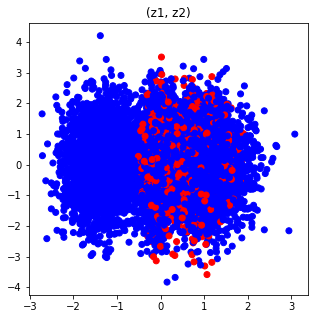

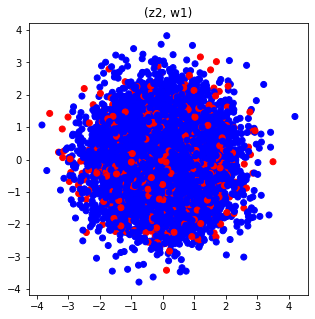

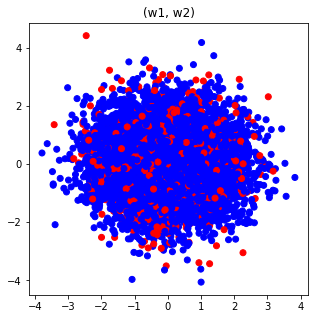

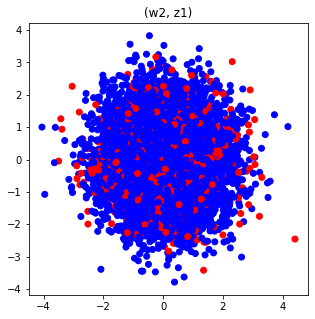

In [124]:
# Usual VAE

plt.figure(figsize=(5, 5,))
plt.title('(z1, z2)')
plt.scatter(z_comp[:, 0], z_comp[:, 1], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(z2, w1)')
plt.scatter(z_comp[:, 1], w_comp[:, 0], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(w1, w2)')
plt.scatter(w_comp[:, 0], w_comp[:, 1], c=colors_test)

plt.figure(figsize=(5, 5,))
plt.title('(w2, z1)')
plt.scatter(w_comp[:, 1], w_comp[:, 0], c=colors_test)

In [ ]:
datasets = {phase: FaceData() for phase in ["train"]}
    dataloaders = {phase: DataLoader(datasets[phase], batch_size=16, shuffle=True, num_workers=0) 
               for phase in ["train"]}

In [ ]:
model = VAE1(hid_dim=256, KOF=24, p=0.04)
model = model.cuda().train()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3/2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[pow(3, i) for i in range(7)], gamma=pow(0.1, 1/7))

0.0005

[1, 3, 9, 27, 81, 243, 729]